# 2 Random 2 Sampling
Abhilash Reddy M,  May 28 2022

This is a sequel to my [previous Jupyter notebook on random sampling](https://abhila.sh/writing/5/Random_Sampling.html) where I covered generating uniformly random points on various domains. This notebook demonstrates sampling in some additional domains and some additional methods. 3D plots herein are drawn using plotly and are interactive. Some online notebook viewer websites do not support interactive plots. So, the plotly plots might not appear. This notebook is available [here](https://github.com/AbhilashReddyM/notebooks/blob/main/random_sampling/Random_Sampling_2.ipynb). For best the experience please [read notebook hosted here](http://abhila.sh/writing//8/Random_Sampling_2.html) or run this notebook somewhere that supports all the features and modules used.

#### Contents
1. [Simplex](#simplex)
    - [Triangles](#trisimp)
    - [Tetrahedra](#tetsimp)
    - [An exercise](#simplexercise)
2. [Sphere](#sphere)

We begin by setting up the notebook environment

In [65]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style() # set the style of matplotlib plots to match the notebook theme
import numpy as np
from numpy.random import uniform,standard_normal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_dark" #make plotly use the plotly_dark theme

## Sampling in a simplex <a name="simplex" ></a>

A [Simplex](https://en.wikipedia.org/wiki/Simplex) is a generalization of triangles (2D) and tetrahedra (3D) to arbitrary dimensions. The name is because it refers to the simplest polytope in a given space. There is a great general algorithm that generates random points in any simplex.

### Sampling in an $K$-dimensional simplex
1. Let $V_{ij}$ be the $[(K+1)\times K]$ array of the vertex coordinates that form a $K$-d simplex 
2. Let $u_i$ be $K+1$ uniform random samples from (0,1]
2. Let $v_i = \dfrac{\ln{u_i}}{\sum_{j=1}^{K+1}{\ln{u_j}}}$
3. $p_i = V_{ji}v_j$ is uniformly random within the simplex

Thats it! 

(I have used index notation above. In $V_{ij}$ $i$ refers to the vertex and $j$ refers to coordinate dimension)

We have started with samples from a uniform distribution and in the second step converted them to an exponential distribution (actually $exp\sim-\ln{u}$, but since we normalize, the signs cancel and hence I have left out the negative signs in the algorithm above) and normalized so that their sum is unity. Now, these are valid barycentric coordinates for some point within the simplex. The random point is simply the weighted sum of the vertices with the barycentric coordinates as weights.

This method needs one extra uniform sample compared so some other methods for lines and triangles. Within a line we can specify a unique point with just one coordinate and within a triangle two barycentric coordinates are enough to identify a unique point. This is because the sum of the barycentric coordinates should be unity for any point inside the simplex. This is not a comment on the efficiency of any method. In fact, I will not comment on the efficiency of the methods here.

A demonstration of this algorithm in 2D is shown below <a name="trisimp"></a>

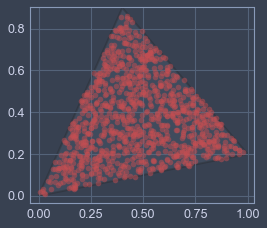

In [66]:
triverts=np.asarray([[0,0],[1.0,0.2],[0.4,0.9]])
fig,ax=plt.subplots(figsize=[4,4], subplot_kw=dict(aspect='equal',))
_=ax.add_artist(plt.Polygon(triverts,alpha=0.3,lw=2,ec='k'))
N=1000
pts=[]
for i in range(N):
    pqr=uniform(size=3)
    pqr=np.log(pqr)
    pqr=pqr/np.sum(pqr)
    pts.append(triverts.T.dot(pqr))
pts=np.asarray(pts)
_=ax.plot(pts[:,0],pts[:,1], 'ro', alpha=0.5)

We can write a general dimension-agnostic function like so:

In [67]:
def simpsRUS(vertices,N):
    """
    Random Uniform Sampling in a K-d simplex
    Input:
        vertices: a list of vertices of the simplex
        N: number of points to be generated
    """
    pts=np.empty((N,vertices.shape[1]))
    n=len(vertices)
    for i in range(N):
        pqr=uniform(size=n)
        pqr=-np.log(pqr)
        pqr=pqr/np.sum(pqr)
        pts[i,:]=vertices.T.dot(pqr)
    return pts

The following block uses this function to get random points inside a triangle

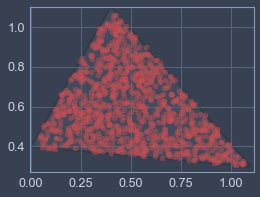

In [68]:
triverts=np.asarray([[0,0.4],[1.1,0.3],[0.4,1.1]])
fig,ax=plt.subplots(figsize=[4,4], subplot_kw=dict(aspect='equal',))
_=ax.add_artist(plt.Polygon(triverts,alpha=0.3,lw=2,ec='k'))
N=1000
pts=simpsRUS(triverts,N)
_=ax.plot(pts[:,0],pts[:,1], 'ro', alpha=0.5)

## Tetrahedron <a name="tetsimp"></a>
Lets try to use this function to sample points inside a tetrahedron. I am going to use `plotly` to make interactive 3D plots

In [69]:
# we need to make a trimesh to plot the tetrahedron
tetverts=np.asarray([[0.1,0,0],[1.1,0.1,0],[0,1.3,0],[1,0,1.2]])
triangles=np.asarray([[0,1,2],[0,1,3],[0,2,3],[1,2,3]])

x, y, z = tetverts.T
i,j,k = triangles.T

N=2000
pts=simpsRUS(tetverts,N)

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='lightblue', opacity=0.25,)])
fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers', marker=dict(size=2, color='red', opacity=0.5)))
fig.show()

Compared to the triangle case, it is challenging if not impossible, to visually determine whether this is uniform, but I assure you that it is. There are tests that can be done to determine the quality of distributions, but that is something for later. Right now, we will go through a small exercise that should convince you that this procedure is uniform for tetrahedra. 

# An Exercise <a name="simplexercise"></a>
We will decompose a cube into tetrahedra. Then we will sample uniformly in the tetrahedral partitions. The result should be a uniform distribution inside the cube, which can be easily seen/tested for uniformity.

There is more than one way to do this decomposition. One way gets us 6 irregular tets of equal volume (actually 6 congruent tets including reflection) and another way gets us 5 tets (4+1). Here, we decompose the cube into 5 tets. It might be a bit challenging to visualize this, so we plot the tets in different color. As you can see below, these are organic hand-crafted, small-batch cube, tetrahedra and triangles. The cube is plotted as a trimesh. Each face of the cube is divided into two triangles.

In [70]:
cube_vertices=np.asarray([[0,0,0], [0,0,1], [0,1,0], [0,1,1], 
                          [1,0,0], [1,0,1], [1,1,0], [1,1,1]],dtype=np.float64)
cube_triangles=np.asarray([ [0,1,3], [0,3,2], [0,2,6], [0,6,4], [0,5,1], [0,4,5], 
                            [1,5,7], [1,7,3], [2,3,7], [2,7,6], [4,6,7], [4,7,5], ],dtype=int)

x,y,z=cube_vertices.T
i,j,k=cube_triangles.T
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k,flatshading=True, opacity=0.5)])

#plotly does not support drawing edges directly. We need to resort to the following hack
#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
tri_points = cube_vertices[cube_triangles]
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])

fig = fig.add_trace(go.Scatter3d(
                   x=Xe,
                   y=Ye,
                   z=Ze,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=2)))
fig.show()

Now we actually decompose the cube into tetrahedra. Again this has been done manually and with great care below.

In [71]:
tet1=np.vstack((cube_vertices[0],cube_vertices[1],cube_vertices[2],cube_vertices[4]))
tet2=np.vstack((cube_vertices[2],cube_vertices[4],cube_vertices[6],cube_vertices[7]))
tet3=np.vstack((cube_vertices[1],cube_vertices[4],cube_vertices[5],cube_vertices[7]))
tet4=np.vstack((cube_vertices[1],cube_vertices[2],cube_vertices[3],cube_vertices[7]))
tet5=np.vstack((cube_vertices[4],cube_vertices[1],cube_vertices[2],cube_vertices[7]))

triangles=np.asarray([[0,1,2],[0,1,3],[0,2,3],[1,2,3]]) # same for all tetrahedra

fig=go.Figure()
for tet in [tet1,tet2,tet3,tet4,np.array([1.5,0,0])+tet5]:
    x, y, z = tet.T
    i,j,k = triangles.T
    fig = fig.add_trace(go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=0.25,))
fig.show()

The figure above shows the cube decomposed into five tets. One of the tets has been drawn separately away from the others. There are two kinds of tets here. Four of them are identical and irregular and have faces made from three half-faces of the cube. These are the ones on the *outside*. The fifth one is a regular tetrahedronin the middle of the cube. Its faces are covered up by the other tets. This fifth tet is drawn separately above. It fits in the gap between the 4 identical tets. This can be unexpectedly tricky to visualize but it does feel great when it "clicks". The volume of this middle tet happens to be twice the volume of the 4 other tets. This needs to be taken into account when we generate the samples.

We will generate 1000 samples in each of the smaller tets and 2000 samples in the big one for a total of 6000 samples. We will use the `simpsRUS` function we defined earlier.

In [72]:
# handle the fifth tet separately
Tpts=[]
fig=go.Figure()
N=1000
for tet in [tet1,tet2,tet3,tet4]:
    pts=simpsRUS(tet,N)
    Tpts.append(pts)
    fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
     mode='markers', marker=dict(size=2, color='red', opacity=0.5)))

pts=simpsRUS(tet5,2*N)
Tpts.append(pts)
Tpts=np.vstack(Tpts)# stack the points from all the tetrahedra
fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
 mode='markers', marker=dict(size=2, color='red', opacity=0.5)))
fig.show()

Visually this looks like what one would expect. Nothing funny jumps out at us. We can check if it is really uniform by looking at the distribution of individual position component separately. We do this by drawing a histogram for each component of all the points below

Text(0, 0.5, 'normalized probability density')

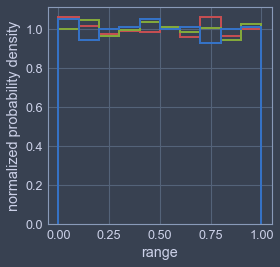

In [73]:
fig,ax=plt.subplots(figsize=[4,4], subplot_kw=dict())
x,y,z=Tpts.T
_=ax.hist([x,y,z], density=True,  histtype='step', lw=2)
ax.set_xlabel("range")
ax.set_ylabel("normalized probability density")

This shows that x,y, and z look like they are drawn from uniform distributions, which is consistent. Let us repeat this experiment but this time keep N=1000 for all tets

In [74]:
Tpts=[]
fig=go.Figure()
N=1000
for tet in [tet1,tet2,tet3,tet4,tet5]:
    pts=simpsRUS(tet,N)
    Tpts.append(pts)
    fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
     mode='markers', marker=dict(size=2, color='red', opacity=0.5)))
fig.show()

It is not immediately apparent that there is something wrong with the points. But when we look at the histogram of the point-coordinates it becomes clear that there is something amiss.

Text(0, 0.5, 'normalized probability density')

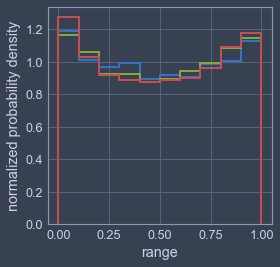

In [75]:
fig,ax=plt.subplots(figsize=[4,4], subplot_kw=dict())
Tpts=np.vstack(Tpts)
x,y,z=Tpts.T
_=ax.hist(x, density=True, histtype='step', lw=2)
_=ax.hist(y, density=True, histtype='step', lw=2)
_=ax.hist(z, density=True, histtype='step', lw=2)
ax.set_xlabel("range")
ax.set_ylabel("normalized probability density")

The histograms show that x,y,z are not from a uniform distribution. There are more points at the edges than at the center. This is due to the relativly fewer points in the larger central tetrahedron. There wasnt a problem before where we accounted for this difference in volumes and assigned the points per tet accordingly. This trick of checking histograms will not work in general. We would have to define and calculate a local point density and check for variations in it. 

Before going to the next section, lets us decompose the unit cube into 6 congruent tetrahedra and generating points once again.

In [76]:
cv=np.asarray([[0,0,0], [0,0,1], [0,1,0], [0,1,1], 
               [1,0,0], [1,0,1], [1,1,0], [1,1,1]],dtype=np.float64) # same as before. shorter name this time :)
#decompose into 6 tetrahedra
tets=np.asarray([
    [cv[0],cv[1],cv[3],cv[7]],
    [cv[0],cv[2],cv[3],cv[7]],
    [cv[0],cv[1],cv[5],cv[7]],
    [cv[0],cv[4],cv[5],cv[7]],
    [cv[0],cv[2],cv[6],cv[7]],
    [cv[0],cv[4],cv[6],cv[7]]])

fig=go.Figure()
for tet in tets:
    x, y, z = tet.T
    i,j,k = triangles.T
    fig = fig.add_trace(go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=0.25,))
fig.show()

That looks like what we expected. It is interesting to note that the points (0,0,0) and (1,1,1) are shared by all 6 tetrahedra. Now lets sample points in these 6 tets and check the histogram of the coordinates to see if things worked correctly. Since the volumes of the tets this time are equal, we do not need to worry about it.

In [77]:
Tpts=[]
fig=go.Figure()
N=1000
for tet in tets:
    pts=simpsRUS(tet,N)
    Tpts.append(pts)
    fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
     mode='markers', marker=dict(size=2, color='red', opacity=0.5)))
fig.show()

Same as before, we calculate the histogram of the x,y and z components of each point.

Text(0, 0.5, 'normalized probability density')

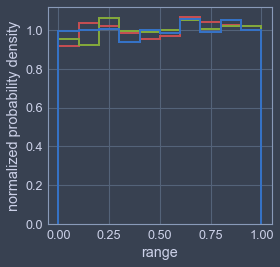

In [78]:
Tpts=np.vstack(Tpts)
fig,ax=plt.subplots(figsize=[4,4], subplot_kw=dict())
x,y,z=Tpts.T
_=ax.hist([x,y,z], density=True,  histtype='step', lw=2)
ax.set_xlabel("range")
ax.set_ylabel("normalized probability density")

This histogram looks fine as well. Now we move on to spheres

## Sphere <a name="sphere"></a>

The previous notebook covered generating points on the surface of a sphere. We can use that as a stepping stone to generate points inside the sphere. Once we have have points on the sphere, we just have to assign a radius to them according to a proper distribution that results in uniform sampling. $r\in \sqrt[3]{U(0,1)}$ will have the right distribution.

In [79]:
N=2000
phi   = uniform(0,2*np.pi,size=N)
theta = np.arccos(uniform(-1,1,size=N))
r     = np.cbrt(uniform(0,1,size=N))

st,ct=np.sin(theta),np.cos(theta)
sp,cp=np.sin(phi),np.cos(phi)

pts=r[:,np.newaxis]*np.c_[st*cp,st*sp,ct]

fig=go.Figure()
fig.add_scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers', marker=dict(size=2, color='red', opacity=0.5))
fig.show()

Thats it for now. [Homepage](http://abhila.sh).